# Efficient Frontier Project

## Importing Libraries & Dependencies

In [13]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

In [15]:
# creating a defined function for importing stock data
def import_securities_data(securities_tickers, enter_time_amount, enter_time_type):

    # time delta method function doesnt take the following date time types, it only takes in days. so we convert the respective time types into days by doing some quick math for the user to convert into days
    other_times_types = ['y', 'Y',  'm', 'M', 'w', 'W']
    
    month_type = ['m', 'M']

    week_type = ['w', 'W']

    year_type = ['y', 'Y']

    # if statement that allows us to make a conditional statement to see if the user has inputted any of the time types listed under the other_times_types variable. if so is the case it moves on to the follwing if conditional statements and executes the respective function under the if statement where the conditional value was true
    if enter_time_type in other_times_types:
        
        if enter_time_type in month_type: 
            
            enter_time_amount = 30 * enter_time_amount

        elif enter_time_type in week_type:

            enter_time_amount = 7 * enter_time_amount
        
        elif enter_time_type in year_type:

            enter_time_amount = 365 * enter_time_amount

    
    # create a variable to assign the end date and start dates of the data that we want to dowload, the start date is dynamic and customizable to the user's preference of the data one wants to download
    # credit to John Droescher for this part of the code
    start_date = dt.datetime.today() - pd.Timedelta(enter_time_amount, "d")
    end_date = dt.datetime.today()
    
    # this returns all of the securities related historical data utilizing yahoo finance's API
    return yf.download(start= start_date, end= end_date, tickers= securities_tickers)

## Part #1:

### Creating Dataframe (Mean & Variance)

In [25]:
# this represente the stock symbols that makes up my stock portfolio of seven stocks
stock_ticks = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'TSLA', 'GOOG']

# importing 2 years worth of Adj Close historical data
portfolio_stock = import_securities_data(stock_ticks, 2, 'y')['Adj Close']

# calculating the daily returns and dropping any nan values as a result from it
portfolio_stock_rets = portfolio_stock.pct_change().dropna()

[*********************100%%**********************]  7 of 7 completed


In [26]:
# the start of the dataframe. we start with housing in the ticker symbols into the ticker column
df= pd.DataFrame(stock_ticks, columns=['ticker'])
df.set_index('ticker', inplace = True)

# calculating the mean of the returns of each asset on our portfolio
df['mean'] = portfolio_stock_rets.mean()

# calculating the variance of each stocks returns
df['variance'] = portfolio_stock_rets.var()

df

,mean,variance
ticker,,
AAPL,0.000459,0.000315
MSFT,0.001020,0.000344
NVDA,0.003526,0.001237
AMZN,0.000748,0.000648
META,0.002491,0.001051
TSLA,-0.000045,0.001354
GOOG,0.000425,0.000463


### Correlation Matrix

<Axes: xlabel='Ticker', ylabel='Ticker'>

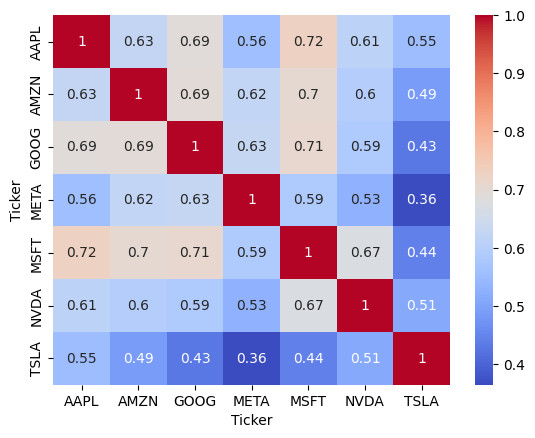

In [22]:
# calcutling the correlation matrix of the portfolio of stocks
corr_port_ret = portfolio_stock_rets.corr()

# plotting the correlation matrix of the stock portfolio in a heatmap to better visualize the correlation between stocks
sns.heatmap(corr_port_ret, annot=True, cmap = 'coolwarm')

## Part #2: Efficient Frontier

### Classes & Definition Method Functions

In [114]:
class functions:

    rets = np.log(portfolio_stock / portfolio_stock.shift(1))
    num_assets = len(stock_ticks)


    @staticmethod
    # create a function method that will calculate and return us the annual returns and volatility in the form of standard deviation
    def portfolioperformance(weights):
        
        # calculating annual returns of the portfolio. we take the weighted returns of each asset and sum it all up and multiply that number by 252 days
        annual_returns = np.sum(functions.rets.mean() * weights) * 252

        # calculating volatility
        annual_covmatrix = functions.rets.cov() * 252  # getting the annual covariance of each stock
        wght_annual_cov = np.dot(annual_covmatrix, weights) # calculating the annualized portfolio covariance of each stock has in the portfolio by getting the weighted contribution (sum product) of each asset's covariacne to the portolio
        annualized_var = np.dot(weights.T, wght_annual_cov) # calculating the annualized portfolio variance
        volatility_std = np.sqrt(annualized_var) # calculating the annualized portfolio standard deviation (volatility)

        # getting annual returns and volatility values from the function method 
        return annual_returns, volatility_std
    

    @staticmethod
    # creating a function method that retrieves the daily risk free rate by getting the annualized risk free rate form Yahoo Finance 3-month treasury yield, converting it to daily
    def riskfreerate():
        
        # import libraries to allow us to webscrape the value from Yahoo Finance's webpage where the 3-month treasury yield is located
        import requests
        from bs4 import BeautifulSoup

        # sending a request to Yahoo Finance api to gain access to the website in html form
        html_text = requests.get('https://finance.yahoo.com/bonds/').text

        # using beauftiful soup library to make the html readable
        soup = BeautifulSoup(html_text, 'lxml')

        # setting a variable to hold the piece of text that we are extracting from the peace of html that holds the 3-month treasury risk free rate value
        risk_free_rate_3m = soup.find('td' , class_ = 'Va(m) Ta(end) Pstart(20px) Fw(600) Fz(s)').text

        # take the text and convert it into a float number, then divide by 100 to get it in decimal formation
        risk_free_rate_3m = (float(risk_free_rate_3m.strip())) / 100

        return risk_free_rate_3m
    

    @staticmethod
    # create a feunction method that will calculate the sharpe ratio using the risk free rate that we get from the riskfreerate function method. we have both calculation (risk free rate and sharpe ratio) seperate because we want to be able to use them in loops, this takes less work for python to calculate the sharpe ratio within the loop becuase it doesnt have to scrape and access the website every time the calculation for the sharpe ratio is looped through
    def calcSharpe(returns, stdv, annualriskfreerate):

        # calculation of the sharpe ratio usin the sharpe ratio formula
        sharpe = (returns - annualriskfreerate) / stdv

        return sharpe
    

    @staticmethod
    # creating definition function to calculate the postive value of the sharpe ratio when trying to minimize the negative sharpe ratios in order to optimize for the maximum sharpe ratio later 
    def poscalcSharpe(weights):

        import requests
        from bs4 import BeautifulSoup

        # sending a request to Yahoo api to gain access to the website in html form
        html_text = requests.get('https://finance.yahoo.com/bonds/').text

        # using beauftiful soup library to make the html readable
        soup = BeautifulSoup(html_text, 'lxml')

        # setting a variable to hold the piece of text that we are extracting from the peace of html that holds the 3-month treasury risk free rate
        risk_free_rate_3m = soup.find('td' , class_ = 'Va(m) Ta(end) Pstart(20px) Fw(600) Fz(s)').text

        # take the text and convert it into a float number
        risk_free_rate_3m = float(risk_free_rate_3m.strip())

        # the risk free rate is set to an annual rate by default. calculate the daily risk free rate as we are dealing with daily data in our pandas dataframe for our returns
        risk_free_rate = risk_free_rate_3m / 100
        
        # getting the returns and standard deviation data thats calculated from the function method
        rets, stdv = functions.portfolioperformance(weights)
        
        # calculating negative sharpe ratio
        pos_sharpe = (rets - risk_free_rate) / stdv

        # returning the positive sharpe ratio
        return pos_sharpe


    @staticmethod
    # creating definition function to calculate the negative value of the sharpe ratio to minimize the negative sharpe ratios later  in order to optimize for the maximum sharpe ratio 
    def negcalcSharpe(weights):

        import requests
        from bs4 import BeautifulSoup

        # sending a request to Yahoo api to gain access to the website in html form
        html_text = requests.get('https://finance.yahoo.com/bonds/').text

        # using beauftiful soup library to make the html readable
        soup = BeautifulSoup(html_text, 'lxml')

        # setting a variable to hold the piece of text that we are extracting from the peace of html that holds the 3-month treasury risk free rate
        risk_free_rate_3m = soup.find('td' , class_ = 'Va(m) Ta(end) Pstart(20px) Fw(600) Fz(s)').text

        # take the text and convert it into a float number
        risk_free_rate_3m = float(risk_free_rate_3m.strip())

        # the risk free rate is set to an annual rate by default. calculate the daily risk free rate as we are dealing with daily data in our pandas dataframe for our returns
        risk_free_rate = risk_free_rate_3m / 100
        
        # getting the returns and standard deviation data thats calculated from the function method
        rets, stdv = functions.portfolioperformance(weights)
        
        # calculating negative sharpe ratio
        neg_sharpe = - (rets - risk_free_rate) / stdv

        # returning the negative sharpe ratio
        return neg_sharpe
    

    @staticmethod
    # optimizing the sharpe ratio, optimizing for the maximum returns for the minimun volatiltiy
    def maxsharpe():
        "minimize the negative sharpe ratio by minimizing the negative sharpe ratios"

        # strict equality statement, stating that all of the summation in the weights of the portfolio are equal to one
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # for every single asset we have a bound between 0 and 1, meaning that the portfolio weight can't exceed 100% of its weight
        bounds =  tuple((0, 1) for x in range(functions.num_assets))

        # this is the initial guess for the weights of the portfolio, we assume that all of portfolio assets are equally weighted in our portfolio
        eweights = np.array(functions.num_assets * [1. / functions.num_assets,])

        # utilizing the scipy optimize sub-library to minimize the negative sharpe ratio and receive the optimal portfolio for the maximum sharpe ratio given the bounds and contraints that were made
        result = sc.optimize.minimize(functions.negcalcSharpe, eweights, method= 'SLSQP', bounds= bounds, constraints= constraints)

        # returning the results from the optimization
        return result
    

    @staticmethod
    # function to only calculate the portfolio volatility. we extract this from our portfolioperformance function method that already calculates this
    def portfoliovolatility(weights):
        return functions.portfolioperformance(weights)[1]


    @staticmethod
    # function method to calculate the portfolio with that minimizes for the volatility. in this case we minimize for the standard deviation since it also minimizes the variance
    def minimizevariance():
        "minimizing the portfolio vairance by minimizing the portoflio weights standard deviations"

        # strict equality statement that all of the summation in the weights of the portfolio are equal to one
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # for every single asset we have a bound between 0 and 1 meaning that the portfolio weight cant exceed 100% of its weight
        bounds =  tuple((0, 1) for x in range(functions.num_assets))

        # this is the initial guess for the weights of the portfolio, we assume that all of portfolio assets are equally weighted in our portfolio
        eweights = np.array(functions.num_assets * [1. / functions.num_assets,])

        # utilizing the scipy optimize sub-library to minimize for the standard deviation and recieve the optimal portfolio for the minimum volatility given the bounds and contraints that were made
        result = sc.optimize.minimize(functions.portfoliovolatility, eweights, method= 'SLSQP', bounds= bounds, constraints= constraints)
        return result
    

    @staticmethod
    # function to only calculate the portfolio returns. we extract this from our portfolioperformance function method that already calculates this
    def port_ret(weights):
        return functions.portfolioperformance(weights)[0]


    @staticmethod
    # function method to calculate the efficient frontier that holds all of the data in relation to the optimal portfolio that gives you the maximized returned for the minimized risk of a specific portfolio target return
    def efficientoptm(target_ret):

        # strict equality statement that all of the summation in the weights of the portfolio are equal to one and that the portfolio returns are equal to the the indicated target returns
        cons = ({'type': 'eq', 'fun': lambda x: functions.port_ret(x) - target_ret},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        
        # for every single asset we have a bound between 0 and 1 meaning that the portfolio weight cant exceed 100% of its weight
        bnds = tuple((0, 1) for x in range(functions.num_assets)) 

        # this is the initial guess for the weights of the portfolio, we assume that all of portfolio assets are equally weighted in our portfolio
        eweights = np.array(functions.num_assets * [1. / functions.num_assets,])
        
        # utilizing the scipy optimize sub-library to minimize for the standard deviation and recieve the optimal portfolio for the minimum volatility given the bounds and contraints that were made
        # in this case we are optimizing for the given target returns that we have implemented in our contraint. so we are finding the portfolio with the minimized volatility for the given target return between our minimal variance portfolio and our maximum sharpe ratio portfolio
        frontier_val = sc.optimize.minimize(functions.portfoliovolatility, eweights, method='SLSQP', bounds=bnds, constraints=cons)
        
        # returning our data
        return frontier_val
    

In [115]:
class eff_frontier():
    
    def __init__(self, dataframe):
        
        self.num_assets = len(stock_ticks)
        self.port_stock = dataframe
        self.rets = np.log(self.port_stock / self.port_stock.shift(1))
        self.montc_portfolio_data = None
        self.montc_maxSharpe_port = None
        self.montc_minVar_port = None
        self.opt_port = None
        self.eff_port = None
        self.maxsharpe_return = None
        self.maxsharpe_stdv = None
        self.minvol_return =  None
        self.minvol_stdv = None


    # creating a function method in order to produce a monte carlo simulation of the efficient frontier
    def montecarlo_sim(self):

        # storing the respective values produced in the simulation into their variables
        prets = [] # stores portfolio returns
        pvols = [] # stores portfolio volatility
        stock_weights = [] # stores portfolio stock weights
        sharpe_ratio = [] # stores portfolio sharpe ratio
        num_ports = 1000000 # the number of portfolios that we want to generate within our monte carlo similation

        risk_free_rate = functions.riskfreerate() # calculated the daily risk free rate and stores it in a variable

        # for loop in order to do the monte carlo simulation the amount of times of the number of portfolios we want to create form the simulation
        for p in range(num_ports):

            # creates random numbers for the number of assets that we have in our portfolio, this is going to be our randomly generated stock weights within our portfolio
            weights = np.random.random(self.num_assets)

            # normalized the weights so that the portfolio weight can equal 1, all of the stock weights that where produced randomly are adjusted so that the sum of the weights are equal to one
            weights /= np.sum(weights)

            # calculated returns adn standard deviation using the respective function method we created
            returns, std = functions.portfolioperformance(weights)

            # calculated the sharpe ratio
            sharpe = functions.calcSharpe(returns, std, risk_free_rate)

            # storing the values that we get from the simulation into the variables that we have created earlier. We also clean our data so that they are visualy better to interpret
            prets.append((returns*100).round(2))
            pvols.append((std*100).round(2))
            stock_weights.append((weights*100).round(0))
            sharpe_ratio.append(sharpe.round(3))

        # convert numerical data into nummpy array
        prets = np.array(prets)
        pvols = np.array(pvols)

        # craeting a dictionary out of our collected data so that we can turn it to a pandas dataframe
        portfolio = {'returns': prets,
                    'volatility': pvols,
                    'sharpe': sharpe_ratio}
        
        # converting te portfolio dictionary which stores our data into a pandas dataframe
        montcarlo_port_data = pd.DataFrame(portfolio)

        # for loop to be able to iterate through out returns dataframe column and extract their name along with an index number attached to it
        for counter,symbol in enumerate(self.rets.columns):

            # we then take the symbol to create a column title for a new column in the port_data dataframe and we assign the respective stock weight by iterating through our stock_weight variable that holds all of our stock weighting data and extract the respective weightings of the stock within the generated portfolio
            montcarlo_port_data[symbol+' Weight'] = [weights[counter] for weights in stock_weights]
        
        self.montc_portfolio_data = montcarlo_port_data
        
        return 


    def calc_opt_motecarlo(self):

        min_volatility = self.montc_portfolio_data['volatility'].min() # getting the portfolio that has the minimum variance
        max_sharpe = self.montc_portfolio_data['sharpe'].max() # getting the portfolio that has the maximum sharpe ratio

        sharpe_portfolio = self.montc_portfolio_data.loc[self.montc_portfolio_data['sharpe'] == max_sharpe] # getting all of the columns that contains the values of the portfolio that has the minimum variance
        min_variance_port = self.montc_portfolio_data.loc[self.montc_portfolio_data['volatility'] == min_volatility] # getting all of the columns that contains the values of the portfolio that has the maximum sharpe ratio
        
        self.montc_maxSharpe_port = sharpe_portfolio
        self.montc_minVar_port = min_variance_port
        
        return 


    def plot_montecarlo(self):

        # plotting our data points derived form our monte carlo simulation
        plt.figure(figsize=(12, 8)) # setting the size of the chart
        plt.scatter(self.montc_portfolio_data['volatility'], self.montc_portfolio_data['returns'], c=self.montc_portfolio_data['sharpe'], marker='o', cmap='coolwarm', edgecolors='black') # plotting results from our monte carlo simulation
        plt.plot(self.montc_maxSharpe_port['volatility'], self.montc_maxSharpe_port['returns'],'y*', markersize=15.0) # plotting results for our max sharpe ratio portfolio within our monte carlo simulation
        plt.plot(self.montc_minVar_port['volatility'], self.montc_minVar_port['returns'],'r*', markersize=15.0) # plotting results for our minimum variance portfolio within our monte carlo simulation
        plt.xlabel('expected volatility') # setting x-axis title
        plt.ylabel('expected return') # setting y-axis title
        plt.colorbar(label='Sharpe ratio') # setting colorbar title

        return


    # creating a function method to calculate all of our results for the efficient frontier simulation using scipy optimization library
    def calculatedresults(self):
        
        # maximum volatility portfolio
        maxsharpe_port = functions.maxsharpe() # calculating our maximum sharpe ratio portfolio
        maxsharpe_ret, maxsharpe_std = functions.portfolioperformance(maxsharpe_port['x']) # calculating the return and standard deviation using the max sharpe ratio portfolio's stock weightings 
        maxpossharpe = functions.poscalcSharpe(maxsharpe_port['x']).round(3) # calculating the postive sharpe ratio, the simulation takes in negative ratios to minimize the ratio and derive the optimal max sharpe ratio portfolio
        maxsharpe_ret_round, maxsharpe_std_round = round(maxsharpe_ret*100,2), round(maxsharpe_std*100,2) # rounding the returns and standard deviation values for better interpreation
        maxsharpe_port_wght = (maxsharpe_port['x'] * 100).round(0) # assigning the optimal stock weightings of the portfolio to a variable and format it for better interpretation
        
        # minimum volatility portfolio
        minvol_port = functions.minimizevariance() # calculating our minimal volatility portfolio
        minvol_ret, minvol_std = functions.portfolioperformance(minvol_port['x']) # calculating the return and standard deviation using the minimal volatility portfolio's stock weightings
        minvolpossharpe = functions.poscalcSharpe(minvol_port['x']).round(3) # calculating the postive sharpe ratio of the optimal portfolio for minimal vaariance using the stock weightings of the portfolio
        minvol_ret_round, minvol_std_round = round(minvol_ret*100,2), round(minvol_std*100,2) # better formating the returns and standard deviation numbers for better interpretation
        minvol_port_wght = (minvol_port['x'] * 100).round(0) # assigning the optimal stock weightings of the portfolio to a variable and format it for better interpretation

        # putting the calculated values of the minimum volatility and maximum sharpe ratio optimal portfolio in a dictionary to later convert it in a pandas dataframe
        optportfolio = {'returns': [maxsharpe_ret_round, minvol_ret_round],
                    'volatility': [maxsharpe_std_round, minvol_std_round],
                    'sharpe': [maxpossharpe, minvolpossharpe]}

        # creating a list of texts that represents the titles for the index in the pandas dataframe
        index = ['max_sharpe_ratio_values', 'min_volatility_values']
        
        # creating pandas dataframe for miminimal variance and max sharpe ratio portfolio values
        opt_port = pd.DataFrame(optportfolio, index = index)

        # for loop to be able to iterate throughout the returns dataframe columns and extract their name along with an index number attached to it
        for counter, symbol in enumerate(self.rets.columns):
            opt_port.loc['max_sharpe_ratio_values', symbol+' Weight'] = maxsharpe_port_wght[counter] # create a new column with the current stock symbol that is being iterated and then attach the weightings of the max sharpe ratio portfolio to the row of the column
            opt_port.loc['min_volatility_values', symbol+' Weight'] = minvol_port_wght[counter] # create a new column with the current stock symbol that is being iterated and then attach the weightings of the minimum variance portfolio to the row of the column

        # efficient frontier
        target_rets = np.linspace(minvol_ret, maxsharpe_ret, 1000) # creating an array of numbers between the minimum varaince portfolio returns and the max sharpe ratio portfolio return. this will serve as our target returns within the efficient frontier
        target_vols = [] # stores the the volatility values for our optimal portfolio based on our target returns
        target_wghts = [] # stores the the stock weightings values for our optimal portfolio based on our target returns
        target_sharpe = [] # stores the the sharpe ratio values for our optimal portfolio based on our target returns
        
        frontier_risk_free_rate = functions.riskfreerate() # gets the risk free rate from the 3-month treasury yield annual rate

        # for loop to iterate through the array of target returns that we have stored in target_ret variable
        for target_ret in target_rets:
            frontier_val = functions.efficientoptm(target_ret) # calculates the optimal portfolio for the given target return
            target_vol = frontier_val['fun'] # extracts the volatility value from the simulation
            target_vols.append((target_vol*100).round(2)) # appends the volatility value to our variable that holds a list of the values
            front_sharpe = functions.calcSharpe(target_ret, target_vol, frontier_risk_free_rate) # calculated the sharpe ratio of the optimal portfolio
            target_sharpe.append(front_sharpe.round(3)) # appends the sharpe ratio to the variable that holds a list of the values
            target_wghts.append((frontier_val['x']*100).round(0)) # appends the weighting of the stocks in the optimal portfolio to the variable that holds a list of the values

        # created a dictionary that holds the respective values of the optimal portfolios given the range of target returns 
        eff_portfolio = {'returns': (target_rets*100).round(2),
                    'volatility': target_vols,
                    'sharpe': target_sharpe}
        
        # creating the pandas dataframe
        eff_port_df = pd.DataFrame(eff_portfolio)
        
        # for loop to be able to iterate throughout the returns dataframe columns and extract their name along with an index number attached to it
        for counter,symbol in enumerate(self.rets.columns):
            eff_port_df[symbol+' Weight'] = [weights[counter] for weights in target_wghts] # create a new column with the current stock symbol that is being iterated and then attach the weighting of the stock within the portfolio to the row of the column

        # returning the pandas dataframe that where created for the minimum varaince and max sharpe ratio portfolio and the efficient frontier portfolio. We also extract certain values form the minimum varaince and max sharpe ratio portfolio to plot them later in a chart
        self.opt_port = opt_port.T
        self.eff_port = eff_port_df
        self.maxsharpe_return = maxsharpe_ret_round
        self.maxsharpe_stdv = maxsharpe_std_round
        self.minvol_return =  minvol_ret_round
        self.minvol_stdv = minvol_std_round

        return


    def plot_efficientfront(self):
        
        # plotting our data points derived form our simulations
        plt.figure(figsize=(12, 8)) # setting the size of the chart
        plt.scatter(self.montc_portfolio_data['volatility'], self.montc_portfolio_data['returns'], c=self.montc_portfolio_data['sharpe'], marker='o', cmap='coolwarm', edgecolors='black') # plotting results from our monte carlo simulation
        plt.plot(self.maxsharpe_stdv, self.maxsharpe_return,'y*', markersize=15.0) # plotting results for our max sharpe ratio optimal portfolio
        plt.plot(self.minvol_stdv, self.minvol_return,'r*', markersize=15.0) # plotting results for our minimum variance optimal portfolio
        plt.plot(self.eff_port['volatility'], self.eff_port['returns'], 'b', lw=4.0) # plotting our efficient frontier target returns optimal portfolios 
        plt.xlabel('expected volatility') # setting x-axis title
        plt.ylabel('expected return') # setting y-axis title
        plt.colorbar(label='Sharpe ratio') # setting colorbar title


        return

## Efficient Frontier Results:

In [108]:
montc_data = eff_frontier(portfolio_stock)
montc_data.montecarlo_sim()

In [109]:
montc_data.calc_opt_motecarlo()

### Monte-Carlo Simulation

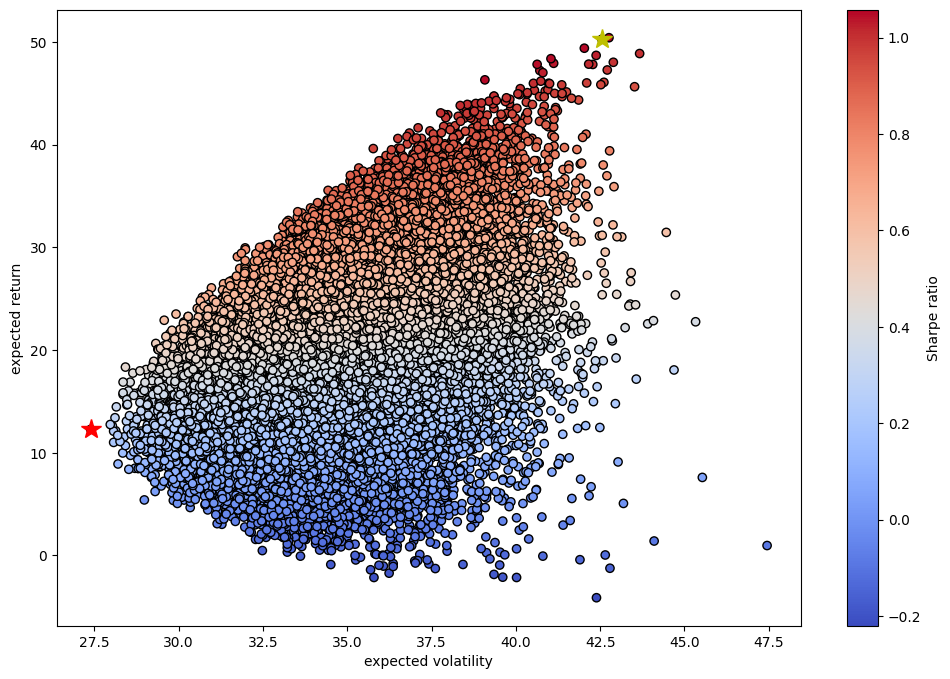

In [110]:
montc_data.plot_montecarlo()

### Monte_Carlo Simulation + Efficient Frontier Line

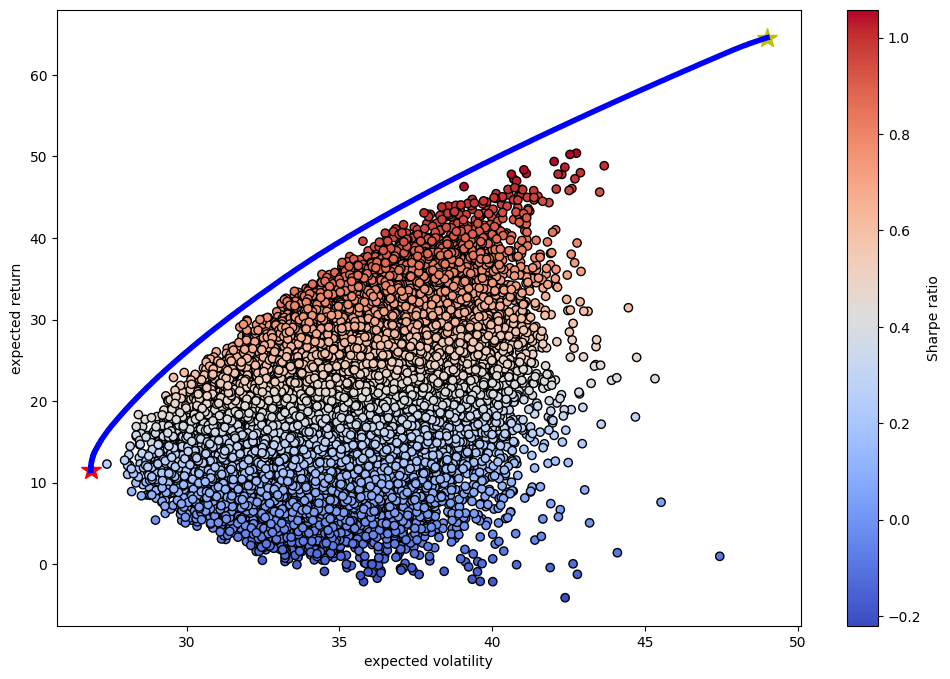

In [116]:
montc_data.calculatedresults()

montc_data.plot_efficientfront()

### Efficient Frontier Portfolio (Minimum Variance to Maximum Sharpe Ratio)

In [118]:
montc_data.eff_port

,returns,volatility,sharpe,AAPL Weight,AMZN Weight,GOOG Weight,META Weight,MSFT Weight,NVDA Weight,TSLA Weight
0,11.50,26.86,0.234,55.0,0.0,5.0,0.0,40.0,0.0,0.0
1,11.55,26.86,0.236,55.0,0.0,5.0,0.0,41.0,0.0,0.0
2,11.60,26.86,0.238,55.0,0.0,4.0,0.0,41.0,0.0,0.0
3,11.66,26.86,0.240,55.0,0.0,4.0,0.0,41.0,0.0,0.0
4,11.71,26.86,0.242,54.0,0.0,4.0,0.0,41.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
995,64.35,48.82,1.211,0.0,0.0,0.0,27.0,0.0,73.0,0.0
996,64.40,48.87,1.211,0.0,0.0,0.0,26.0,0.0,74.0,0.0
997,64.45,48.91,1.211,0.0,0.0,0.0,26.0,0.0,74.0,0.0
998,64.51,48.95,1.211,0.0,0.0,0.0,26.0,0.0,74.0,0.0


### Low Volatility and High Sharpe Ratio Portfolios

In [117]:
montc_data.opt_port

,max_sharpe_ratio_values,min_volatility_values
returns,64.560,11.500
volatility,49.000,26.860
sharpe,1.211,0.234
AAPL Weight,0.000,55.000
AMZN Weight,0.000,0.000
GOOG Weight,0.000,5.000
META Weight,26.000,0.000
MSFT Weight,0.000,40.000
NVDA Weight,74.000,0.000
TSLA Weight,0.000,0.000


# Credits: 

#### Monte Carlo: https://www.youtube.com/watch?v=wlaLmM_LvWg&ab_channel=SpencerPao

#### Efficient Frontier: https://www.youtube.com/playlist?list=PLqpCwow11-OooQGB3vuiCdsRLQ5i-6AEH

#### Object Oriented Programming (for understanding classes and functions): https://www.youtube.com/watch?v=JeznW_7DlB0&t=827s

#### Python for Finance: Mastering Data-Driven Finance, Author: Hilpisch, Yves, Publisher: O'Reilly Media, Incorporated, Edition: 2, Year Published: 2018 (Pg. 415 - 428)